In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.datasets
import altair as alt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None

In [2]:
iris = sklearn.datasets.load_iris(as_frame=True)
irisX = iris.data
scaler = StandardScaler()
irisX = scaler.fit_transform(X=irisX)
irisy = iris.target
setA = irisy <= 1
setB = irisy > 0
setC = irisy != 1

irisAX = irisX[setA]
irisAy = irisy[setA]
irisBX = irisX[setB]
irisBy = irisy[setB] - 1
irisCX = irisX[setC]
irisCy = irisy[setC]/2

trainXs = [irisAX,irisBX,irisCX]
trainys = [irisAy,irisBy,irisCy]

In [3]:
trainX, testX, trainy, testy = train_test_split(
    irisAX,
    irisAy,
    test_size=0.2)

In [4]:
# creates a random unit vector of ndim dimensions
def ruvect(ndim):
    out=[]
    for i in range(ndim):
        out.append(np.random.randint(-100,100))
    out = np.array(out)
    out = out/np.linalg.norm(out)
    return out

In [5]:
# finds centroid of list of points in np array of nxd dimensions, returns point of d dims
def calc_centroid(cluster):
    return np.mean(cluster, axis=0)

In [6]:
# X and y expected to be numpy arrays where y only contains 0's and 1's
def lda(X,y):
    # 1 is for intercept L(w) = w0 + w1x1 + w2x2 +...+ wdxd
    w = ruvect(X.shape[1]) 
    
    # adds a column of 1's to front (for intercept) -- unecessary as position of w doesnt matter
#     X = np.append(np.array([[1] * X.shape[0]]).T, X, axis=1)
    X0 = X[y==0]
    X1 = X[y==1]
    
    # Centroids of data (d dimensional)
    mu0 = calc_centroid(X0)
    mu1 = calc_centroid(X1)
    
    B = np.einsum("i,j->ij", mu0-mu1, mu0-mu1)
    S = np.einsum("Nd,Ni->di", X0-mu0, X0-mu0)
    eta = 0.1
    djw_norm = 100
    iters = 0
    while djw_norm > 0.01 and iters<500:
        # Derivative of J w
        djnum1 = 2*np.matmul(B,w)*(np.matmul(np.matmul(w,S),w))
        djnum2 = 2*np.matmul(S,w)*(np.matmul(np.matmul(w,B),w))
        djdem = np.matmul(np.matmul(w,S),w)**2
        
        djw = (djnum1-djnum2)/djdem
        w = w + eta*djw
        djw_norm = np.linalg.norm(djw)
#         print(djw_norm, w)
        iters+=1
    
    return w,(np.dot(w,mu0)+np.dot(w,mu1))/2

def lda_pred(w,sep,X):
    projs=np.matmul(w,X.T)
    return projs>sep

In [18]:
def logreg(X,y):
    w = ruvect(X.shape[1]+1)
    X = np.append(np.array([[1] * X.shape[0]]).T, X, axis=1) # add intercept col

    eta=0.1
    errmag = 100
    iters=0
    while errmag> 0.1 and iters<100:
        Xw = np.einsum("Nd,d->N",X,w)
        phat = np.divide(1,1+np.exp(-Xw))
        derror = np.einsum("N,Nd->d",y-phat,X)
        
        w += eta*derror
        errmag = np.linalg.norm(derror)
        iters+=1
    return w

def logreg_pred(w,X):
    X = np.append(np.array([[1] * X.shape[0]]).T, X, axis=1) # add intercept column
    return 1.0/(1-np.exp(np.einsum("Nd,d->N",X,w))) < 0.5

# Comparison

In [8]:
lda_ws=[]
lda_seps=[]

lda_sk = LinearDiscriminantAnalysis(solver="lsqr")
lda_sk_ws=[]
lda_sks=[]
for X,y in zip(trainXs,trainys):
    w,sep = lda(X,y)
    lda_ws.append(w)
    lda_seps.append(sep)
    
    lda_sk.fit(X,y)
    lda_sk_ws.append(lda_sk.coef_)
    lda_sks.append(lda_sk)
lda_ws=np.asarray(lda_ws)
lda_sk_ws = np.asarray(lda_sk_ws)[:,0]
lda_sk_ws, lda_ws

(array([[ -2.57087266,  -7.9891543 ,  39.07707289,  23.91029053],
        [ -2.9949196 ,  -2.47287142,  12.51354182,   9.60161648],
        [-13.34069387,  -5.3282304 ,  65.56182743,  28.49466302]]),
 array([[-0.48844082, -0.80704169, -0.09723598, -0.31726222],
        [-0.05718195, -0.19918425,  0.17481237,  0.97711932],
        [-0.30033153,  0.48460678, -8.86415926, -3.49888311]]))

In [9]:
# np.einsum("ij,ij->ij",lda_ws,1/np.array(lda_sk_ws))
for w,wsk in zip(lda_ws, lda_sk_ws):
    print(abs(np.dot(w,wsk)/(np.linalg.norm(w)*np.linalg.norm(wsk))))

0.0790615523791202
0.7426755174929976
0.9760373098352984


## Cosine similarity between sklearn's LDA w and my LDA w is pretty high for each classification problem of Iris.

## Depending on the initial w, my LDA can sometimes produce poor results for IrisB, below is a visualization of the separation made by my LDA, you can see that there is some overalap

<AxesSubplot:xlabel='pos', ylabel='class'>

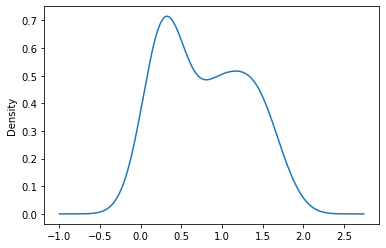

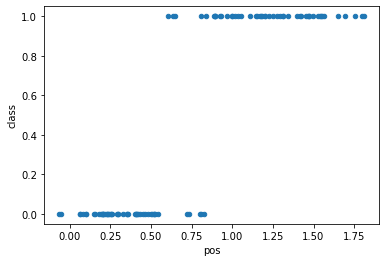

In [10]:
w=lda_ws[1]
projs=np.matmul(w,irisBX.T)
pd.Series(projs).plot.density()
pd.DataFrame(data={"pos":projs,"class":irisBy}).plot.scatter(x="pos",y="class")

<AxesSubplot:xlabel='pos', ylabel='class'>

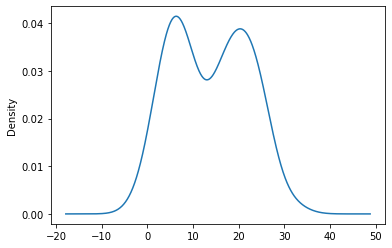

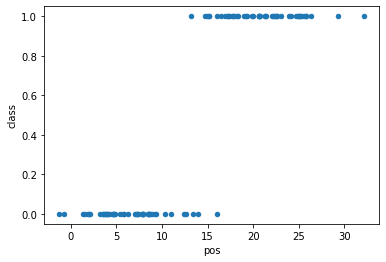

In [11]:
w=lda_sk_ws[1]
projs=np.matmul(w,irisBX.T)
pd.Series(projs).plot.density()
pd.DataFrame(data={"pos":projs,"class":irisBy}).plot.scatter(x="pos",y="class")

In [12]:
for i in range(3):
    y = trainys[i]
    X = trainXs[i]
    pred_sk = lda_sks[i].predict(X)
    pred = lda_pred(lda_ws[i],lda_seps[i],X)
    print(f"Set: {i}\n-------\nSK: \n{confusion_matrix(y,pred_sk)}\nME: \n{confusion_matrix(y,pred)}\n+++++++\n")
#     confusion_matrix(y_true=trainy,y_pred=lda_pred(lda_ws[1],lda_seps[1],irisBX))

Set: 0
-------
SK: 
[[50  0]
 [ 1 49]]
ME: 
[[27 23]
 [27 23]]
+++++++

Set: 1
-------
SK: 
[[ 1 49]
 [ 0 50]]
ME: 
[[47  3]
 [ 3 47]]
+++++++

Set: 2
-------
SK: 
[[50  0]
 [ 0 50]]
ME: 
[[ 0 50]
 [50  0]]
+++++++



In [13]:
lda_sks[1].predict(trainXs[1])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## For the lsqe solver, sklearn's implementation does worse than mine for irisB, so the disimilarity between w's is favoring my implementation 

In [16]:
logreg_ws=[]

logreg_sk_ws=[]
logreg_sks=[]
for X,y in zip(trainXs,trainys):
    w = logreg(X,y)
    logreg_ws.append(w)
    
    logreg_sk = LogisticRegression()
    logreg_sk.fit(X,y)
    logreg_sks.append(logreg_sk)
    logreg_sk_ws.append([np.append(logreg_sk.intercept_,logreg_sk.coef_)])
    
    
logreg_ws=np.asarray(logreg_ws)
logreg_sk_ws = np.asarray(logreg_sk_ws)[:,0]
logreg_sk_ws, logreg_ws

(array([[ 2.40419012,  1.04748083, -1.23549372,  1.74059586,  1.593547  ],
        [-3.80087392,  0.13982863, -0.51454121,  2.47982385,  3.1404283 ],
        [ 0.81588832,  0.89164251, -0.72300173,  1.42585118,  1.45394647]]),
 array([[ 3.27351266,  2.25139774, -4.06846893,  3.80311372,  4.20891374],
        [-9.05953581, -0.95320631, -1.33777609,  6.98955872,  7.28207949],
        [-0.96645706,  6.16139764, -3.8412057 ,  7.50749603,  8.15322811]]))

In [15]:
for w,wsk in zip(logreg_ws, logreg_sk_ws):
    print(abs(np.dot(w,wsk)/(np.linalg.norm(w)*np.linalg.norm(wsk))))

0.9530610385820076
0.9939006485643167
0.9177107532836366


## Cosine similarity is much 'better' for logistic regression, classification is more accurate across all data subsets, and implementations agree

In [19]:
for i in range(3):
    y = trainys[i]
    X = trainXs[i]
    pred_sk = logreg_sks[i].predict(X)
    pred = logreg_pred(logreg_ws[i],X)
    print(f"Set: {i}\n-------\nSK: \n{confusion_matrix(y,pred_sk)}\nME: \n{confusion_matrix(y,pred)}\n+++++++\n")
#     confusion_matrix(y_true=trainy,y_pred=lda_pred(lda_ws[1],lda_seps[1],irisBX))

Set: 0
-------
SK: 
[[50  0]
 [ 0 50]]
ME: 
[[50  0]
 [ 0 50]]
+++++++

Set: 1
-------
SK: 
[[48  2]
 [ 2 48]]
ME: 
[[48  2]
 [ 1 49]]
+++++++

Set: 2
-------
SK: 
[[50  0]
 [ 0 50]]
ME: 
[[50  0]
 [ 0 50]]
+++++++

